Kmeans Clustering


In [101]:
# import libraries

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyarrow.parquet as pq
import time

In [102]:
# suppress warnings

import warnings
warnings.filterwarnings('ignore')

Import database 

In [103]:
# Set the folder path containing the Parquet files
folder_path = 'C:\DSGP_Git\PHM-Clustering\parquet files'

# Get a list of all Parquet file paths in the folder
file_paths = sorted([os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.parquet')])

# Create an empty list to store the Pandas data frames
dfs = []

# Loop through the file paths, read each Parquet file as a Pandas data frame, and append it to the list
for file_path in file_paths:
    table = pq.read_table(file_path)
    df = table.to_pandas()
    dfs.append(df)

# Concatenate all Pandas data frames into a single data frame
df = pd.concat(dfs, ignore_index=True)

In [104]:
# The whole data frame is stored in `df`

df_pdmp = pd.DataFrame(df["pdmp"].tolist())   # Selecting the `pdmp` column
df_pin = pd.DataFrame(df["pin"].tolist())   # Selecting the `pin` column
df_po = pd.DataFrame(df["po"].tolist())   # Selecting the `po` column

In [105]:
# Assign "fault_class" values to y_true series

fault_true = df["fault_class"]

Perfom clustering with PCA

In [106]:
# Perform PCA and set components

# set number of pca components

n_components = 10

pca = PCA(n_components)

principal_components_pdmp = pca.fit_transform(df_pdmp)
principal_components_pin = pca.fit_transform(df_pin)
principal_components_po = pca.fit_transform(df_po)

In [107]:
# Create a dataframes with the principal components

df_pdmp_pca = pd.DataFrame(data=principal_components_pdmp, index=df_pdmp.index)
df_pin_pca = pd.DataFrame(data=principal_components_pin, index=df_pin.index)
df_po_pca = pd.DataFrame(data=principal_components_po, index=df_po.index)

In [108]:
# Perform K means clustering and assign new column 'cluster' with cluster label to df

def KNN_pca(df_list, num_clusters):

    for index, df in enumerate(df_list):

        start_time = time.time()

        # Initialize a KMeans object with the desired number of clusters
        kmeans = KMeans(n_clusters=num_clusters)
        # Fit the KMeans model to the dataset
        kmeans.fit(df)
        # Assign the cluster labels to each row of the original dataset
        df['cluster'] = kmeans.labels_

        end_time = time.time()
        processing_time = end_time - start_time

        if index == 0:
            print(f"Processing time for pdmp sensor: {processing_time:.3f} seconds")
        elif index == 1:
            print(f"Processing time for pin sensor: {processing_time:.3f} seconds")
        elif index == 2:
            print(f"Processing time for po sensor: {processing_time:.3f} seconds")

# set df list and number of clusters
KNN_pca([df_pdmp_pca, df_pin_pca, df_po_pca], num_clusters=11)

# Each row is now assigned a cluster label

Processing time for pdmp sensor: 0.824 seconds
Processing time for pin sensor: 1.015 seconds
Processing time for po sensor: 0.877 seconds


Plot the clusters on a scatter plot against first two PCA components

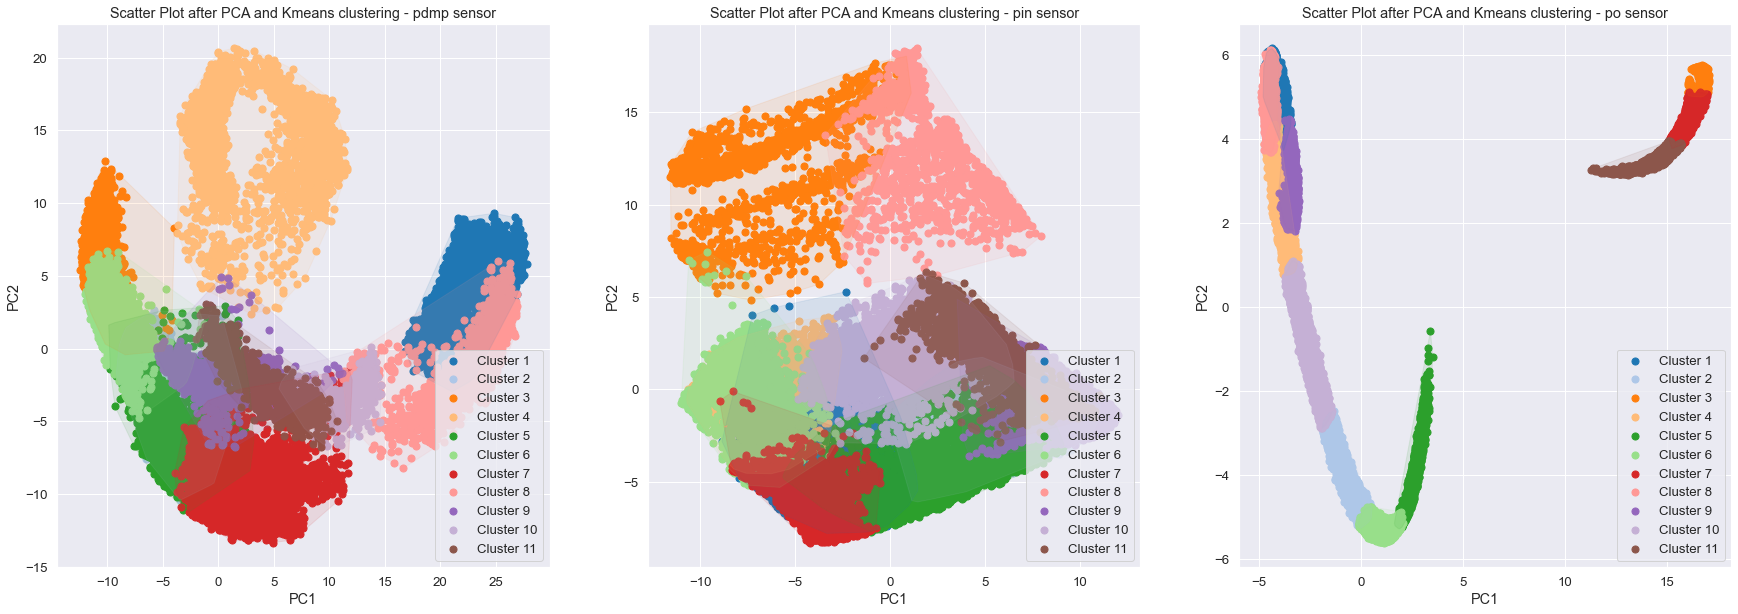

In [109]:
# Define function to plot clusters against first two PCA components
def plot_clusters(df_list, num_clusters):

    # Create a list of unique colors for each cluster
    colors = sns.color_palette('tab20', num_clusters)
    # Create a figure with subplots for each dataframe in df_list
    fig, axs = plt.subplots(1, len(df_list), figsize=(10*len(df_list), 10))

    # Create a separate scatter plot for each dataframe in df_list
    for j, df in enumerate(df_list):
        
        # Set the title of the current subplot
        if j == 0:
            title = 'Scatter Plot after PCA and Kmeans clustering - pdmp sensor'
        elif j == 1:
            title = 'Scatter Plot after PCA and Kmeans clustering - pin sensor'
        elif j == 2:
            title = 'Scatter Plot after PCA and Kmeans clustering - po sensor'
        ax = axs[j]
        for i in range(num_clusters):

            # Plot the points in the current cluster with a unique color
            ax.scatter(df.loc[df['cluster']==i, 0], df.loc[df['cluster']==i, 1], color=colors[i], s=50, label=f'Cluster {i+1}')
            ax.set_title(title)
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            ax.legend(loc='lower right')

        # Draw convex hulls around each cluster
        for i in range(num_clusters):
            cluster_points = df.loc[df['cluster']==i, [0, 1]]
            hull = ConvexHull(cluster_points)
            ax.fill(cluster_points.iloc[hull.vertices, 0], cluster_points.iloc[hull.vertices, 1], color=colors[i], alpha=0.1)

    # Display the plot
    plt.show()

# Call function with three dataframes df_pca1, df_pca2, df_pca3 and 11 clusters:
plot_clusters([df_pdmp_pca, df_pin_pca, df_po_pca], num_clusters=11)

Compare cluster label with actual fault label using a heatmap for each of the sensors

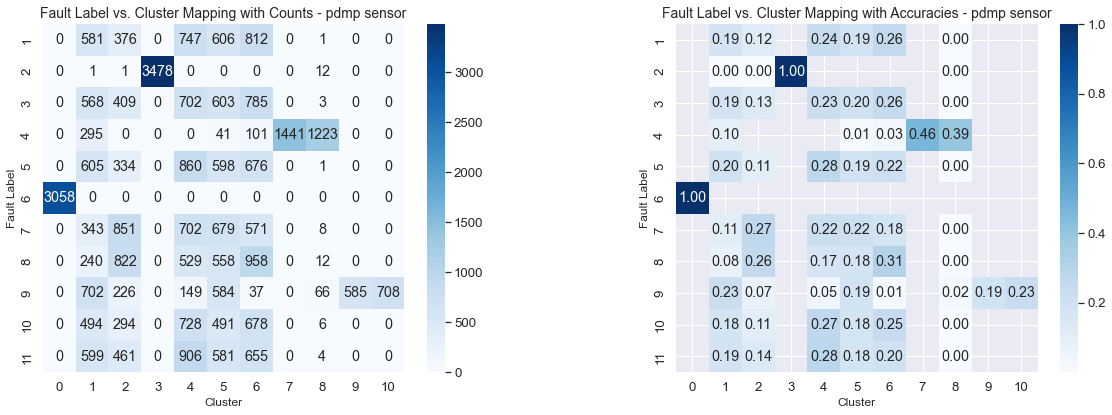

In [110]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_pdmp_pca["cluster"])

# calculate the accuracy of each group
grouped = df_pdmp_pca.groupby([fault_true, df_pdmp_pca["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - pdmp sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - pdmp sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


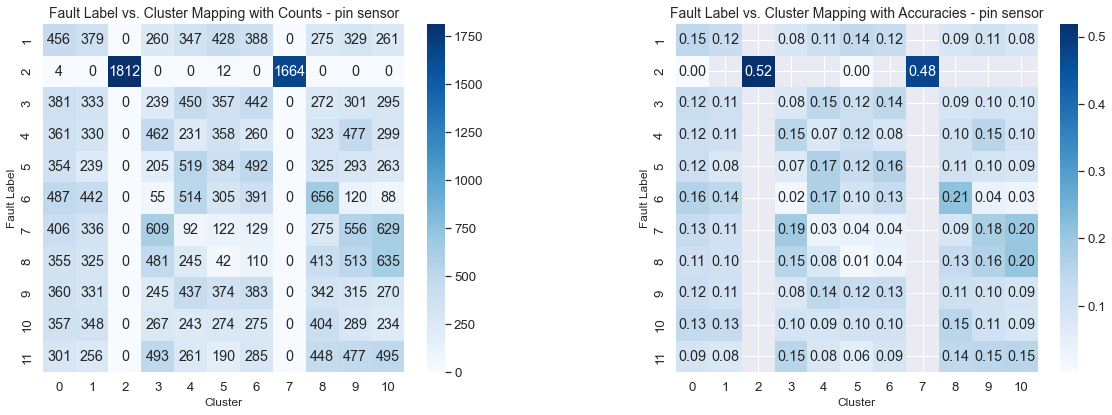

In [111]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_pin_pca["cluster"])

# calculate the accuracy of each group
grouped = df_pin_pca.groupby([fault_true, df_pin_pca["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - pin sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - pin sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


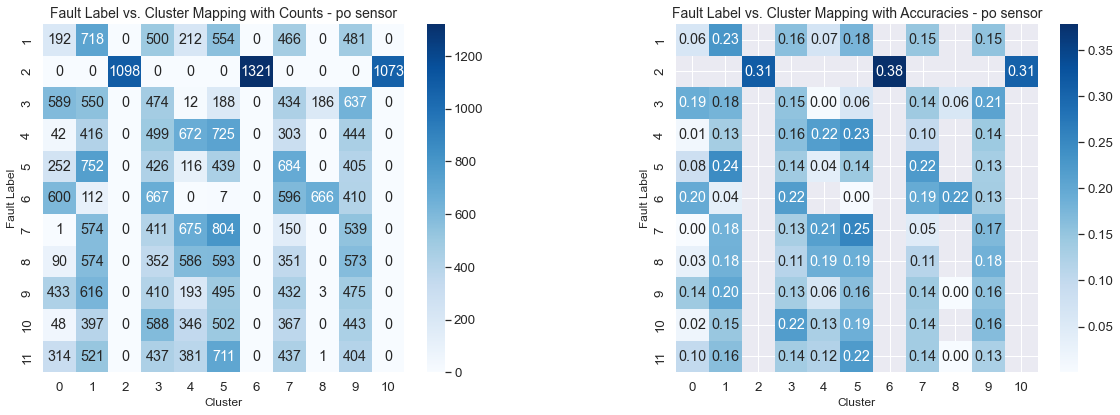

In [112]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_po_pca["cluster"])

# calculate the accuracy of each group
grouped = df_po_pca.groupby([fault_true, df_po_pca["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - po sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - po sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


Perform clustering without PCA

In [113]:
def KNN(df_list, num_clusters):
    
    for index, df in enumerate(df_list):
        start_time = time.time()
        
        # create a KMeans object
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(df)
        cluster_labels = kmeans.labels_
        df['cluster'] = cluster_labels

        end_time = time.time()
        processing_time = end_time - start_time

        if index == 0:
            print(f"Processing time for pdmp sensor: {processing_time:.3f} seconds")
        elif index == 1:
            print(f"Processing time for pin sensor: {processing_time:.3f} seconds")
        elif index == 2:
            print(f"Processing time for po sensor: {processing_time:.3f} seconds")

# set df list and number of clusters
KNN([df_pdmp, df_pin, df_po], num_clusters=11)

Processing time for pdmp sensor: 10.987 seconds
Processing time for pin sensor: 12.160 seconds
Processing time for po sensor: 13.903 seconds


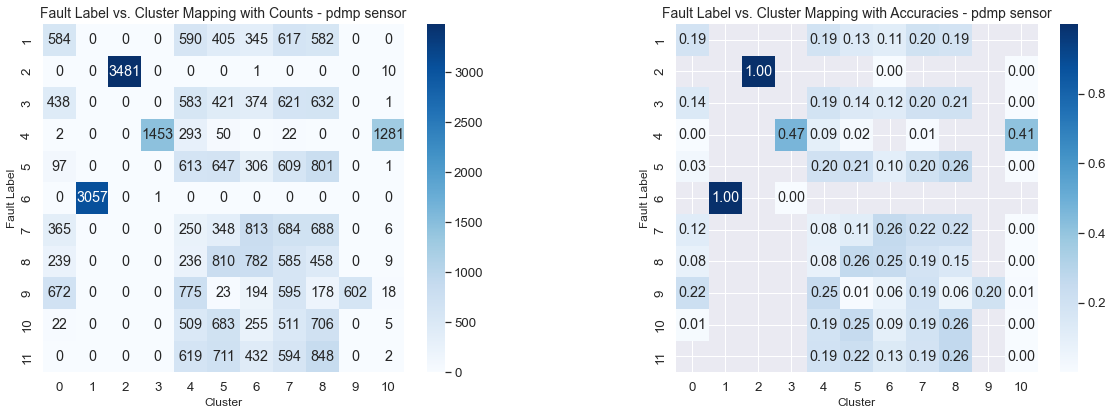

In [114]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_pdmp["cluster"])

# calculate the accuracy of each group
grouped = df_pdmp.groupby([fault_true, df_pdmp["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - pdmp sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - pdmp sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


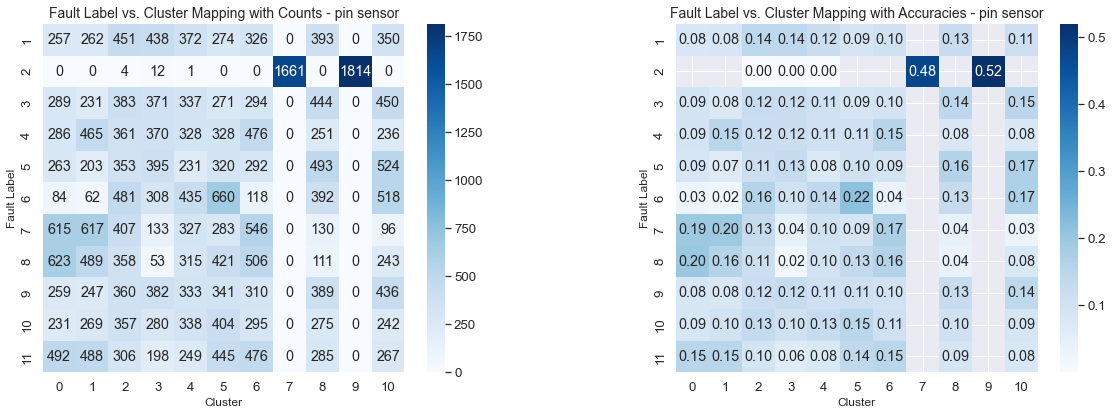

In [115]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_pin["cluster"])

# calculate the accuracy of each group
grouped = df_pin.groupby([fault_true, df_pin["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - pin sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - pin sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()

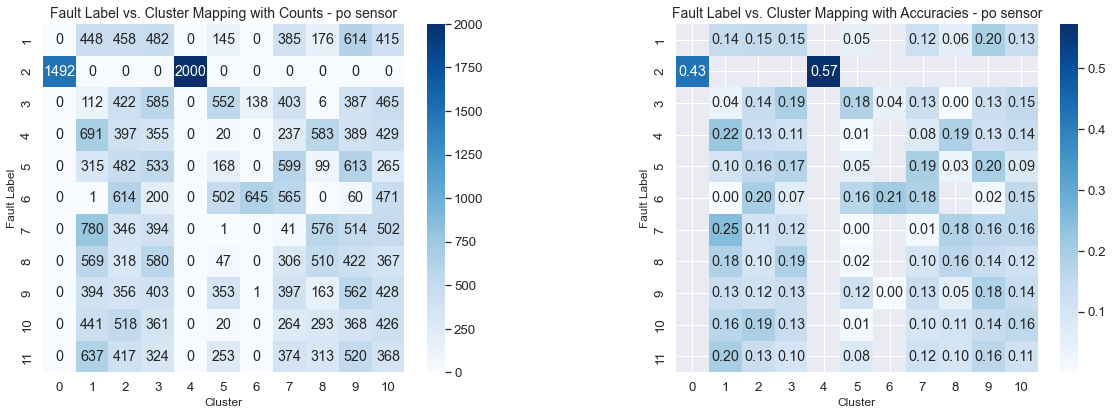

In [116]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_po["cluster"])

# calculate the accuracy of each group
grouped = df_po.groupby([fault_true, df_po["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - po sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - po sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()
